## Last test at Colab : 2022-04-26

## 한글



*   이론 :  https://wikidocs.net/164365 and https://wikidocs.net/164823  and https://wikidocs.net/164835 
*   구현 : https://wikidocs.net/165034  and https://wikidocs.net/164499 


## English


*   Theory : https://wikidocs.net/165403 and https://wikidocs.net/165405  and https://wikidocs.net/165406 
*   Implementation : https://wikidocs.net/165443  and https://wikidocs.net/165444 



In [1]:
import torch
import torch.nn as nn

In Pytorch, the syntax is different from Tensorflow, so "import torch.nn.functional" is used to configure the Network.

In [2]:
import torch.nn.functional as F

### Below part is same with FFN.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



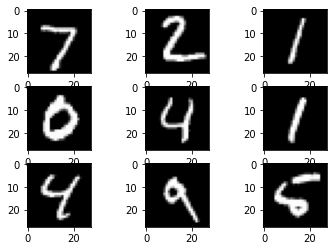

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 256 
num_classes = 10
EPOCHS = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_ds = torch.utils.data.DataLoader(dataset=train_dataset,
                                       batch_size=batch_size, 
                                       shuffle=True)

test_ds = torch.utils.data.DataLoader(dataset=test_dataset,
                                      batch_size=batch_size, 
                                      shuffle=False)

# plot first few images
examples = iter(test_ds)
example_data, example_targets = examples.next()

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(example_data[i][0], cmap=plt.get_cmap('gray'))
    # if you want to invert color, you can use 'gray_r'. this can be used only for MNIST, Fashion MNIST not cifar10
    # pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray_r'))
    
# show the figure
plt.show()

Then, all you have to do is specify the Model as follows. The convolution layer only needs to know the kernel size, the number of filyers, activation, and input size. In the code below, compared to the previous FFN, three convolution layers and a pooling layer are added. Then we need "x = x.view(x.size(0), -1)" to connect to the Linear layer.

It is worth remembering that the flattening method is different compared to TensorFlow.

In [4]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.relu1(x)
        
        # Max pool 1
        x = self.maxpool1(x)
        
        # Convolution 2 
        x = self.cnn2(x)
        x = self.relu2(x)
        
        # Max pool 2 
        x = self.maxpool2(x)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        x = x.view(x.size(0), -1)

        # Linear function (readout)
        out = self.fc1(x)
        
        return out
# model = CNN_Model(input_size, hidden_size, num_classes).to(device)
model = CNN_Model().to(device)

### Below part is same with FFN.

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_ds)

def train_step(model, images, labels):
    model.train()
    # origin shape: [100, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_val = loss.item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Pytorch need a manual coding for accuracy
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)           
    n_samples = labels.size(0)
    n_correct = (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    return loss_val, acc

def test_step(model, images, labels):
    model.eval()
    # origin shape: [100, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_val = loss.item()

    # Pytorch need a manual coding for accuracy
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)           
    n_samples = labels.size(0)
    n_correct = (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    return loss_val, acc

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(EPOCHS):
    
    with tqdm_notebook(total=len(train_ds), desc=f"Train Epoch {epoch+1}") as pbar:    
        train_losses = []
        train_accuracies = []
        
        for i, (images, labels) in enumerate(train_ds):
         
            loss_val, acc = train_step(model, images, labels)
            
            train_losses.append(loss_val)
            train_accuracies.append(acc)
            
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")


    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        
        with tqdm_notebook(total=len(test_ds), desc=f"Test_ Epoch {epoch+1}") as pbar:    
            test_losses = []
            test_accuracies = []

            for images, labels in test_ds:
                loss_val, acc = test_step(model, images, labels)

                test_losses.append(loss_val)
                test_accuracies.append(acc)

                pbar.update(1)
                pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")
            


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Train Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test_ Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]